In [1]:
# STEP 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
import random, os
from xgboost import plot_importance

In [2]:
# STEP 2: Fix random seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

In [3]:
# STEP 3: Load data
df = pd.read_csv("DATASET_MLBA_FINAL.csv")
df.head()

,company_id,company_name,sector,revenue_usd_mn,carbon_emissions_tCO2,emission_intensity_tCO2_per_mn_usd,energy_mix_renewable_pct,fines_count,fines_amount_usd_k,public_sentiment_score,esg_score_reported,gri_compliance_pct,waste_generated_tons,waste_recycled_pct
0,CMP100000,"Rodriguez, Figueroa and Sanchez",Retail,8.721,106.5980,16.0464,23.83,1,20.30,0.903,65.30,50.82,414.17,35.82
1,CMP100001,Doyle Ltd,Transport,1.774,660.6815,84.3515,12.24,3,18.82,0.914,67.94,61.15,167.51,28.00
2,CMP100002,"Mcclain, Miller and Henderson",Energy,16.107,1289.0190,101.9488,21.50,0,0.00,0.935,63.97,50.60,2112.20,36.32
3,CMP100003,Davis and Sons,Retail,42.548,426.3030,10.0193,0.00,6,53.98,0.744,45.12,34.86,2211.35,30.02
4,CMP100004,"Guzman, Hoffman and Baldwin",Manufacturing,37.177,1443.8030,45.7046,15.03,0,0.00,0.839,64.41,55.36,3206.17,36.88


In [4]:
print("Columns in your dataset:\n")
print(df.columns.tolist())

Columns in your dataset:

['company_id', 'company_name', 'sector', 'revenue_usd_mn', 'carbon_emissions_tCO2', 'emission_intensity_tCO2_per_mn_usd', 'energy_mix_renewable_pct', 'fines_count', 'fines_amount_usd_k', 'public_sentiment_score', 'esg_score_reported', 'gri_compliance_pct', 'waste_generated_tons', 'waste_recycled_pct']


In [5]:
# STEP 4: Rename columns so the rest of the notebook uses consistent names
df = df.rename(columns={
    'carbon_emissions_tCO2': 'carbon_emissions',
    'energy_mix_renewable_pct': 'renewable_pct',
    'waste_generated_tons': 'waste_generated_tons',
    'waste_recycled_pct': 'waste_recycled_pct',
    'fines_amount_usd_k': 'fines_amount',
    'gri_compliance_pct': 'gri_adherence',
    'esg_score_reported': 'esg_score',
    'public_sentiment_score': 'sentiment_score'
})

print("✅ Columns renamed. Current columns:")
print(df.columns.tolist())
df.head()

✅ Columns renamed. Current columns:
['company_id', 'company_name', 'sector', 'revenue_usd_mn', 'carbon_emissions', 'emission_intensity_tCO2_per_mn_usd', 'renewable_pct', 'fines_count', 'fines_amount', 'sentiment_score', 'esg_score', 'gri_adherence', 'waste_generated_tons', 'waste_recycled_pct']


,company_id,company_name,sector,revenue_usd_mn,carbon_emissions,emission_intensity_tCO2_per_mn_usd,renewable_pct,fines_count,fines_amount,sentiment_score,esg_score,gri_adherence,waste_generated_tons,waste_recycled_pct
0,CMP100000,"Rodriguez, Figueroa and Sanchez",Retail,8.721,106.5980,16.0464,23.83,1,20.30,0.903,65.30,50.82,414.17,35.82
1,CMP100001,Doyle Ltd,Transport,1.774,660.6815,84.3515,12.24,3,18.82,0.914,67.94,61.15,167.51,28.00
2,CMP100002,"Mcclain, Miller and Henderson",Energy,16.107,1289.0190,101.9488,21.50,0,0.00,0.935,63.97,50.60,2112.20,36.32
3,CMP100003,Davis and Sons,Retail,42.548,426.3030,10.0193,0.00,6,53.98,0.744,45.12,34.86,2211.35,30.02
4,CMP100004,"Guzman, Hoffman and Baldwin",Manufacturing,37.177,1443.8030,45.7046,15.03,0,0.00,0.839,64.41,55.36,3206.17,36.88


In [6]:
# STEP 5: Generate synthetic Green Credit Score (GCS)

import numpy as np

# domain-based weights (positive = good indicator, negative = bad)
weights = {
    "carbon_emissions": -0.35,
    "renewable_pct": 0.25,
    "waste_generated_tons": -0.15,
    "waste_recycled_pct": 0.10,
    "fines_amount": -0.10,
    "gri_adherence": 0.15,
    "esg_score": 0.35,
    "sentiment_score": 0.10
}

# handle missing values for sentiment etc.
df_filled = df.copy()
df_filled['sentiment_score'] = df_filled['sentiment_score'].fillna(df_filled['sentiment_score'].mean())

# normalize each feature to 0–100
def normalize_0_100(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-9) * 100

for col in weights.keys():
    df_filled[col] = normalize_0_100(df_filled[col])

# weighted sum + small random noise
s = sum(df_filled[c] * w for c, w in weights.items())
s = (s - s.min()) / (s.max() - s.min() + 1e-9) * 100
noise = np.random.normal(0, 3, size=len(s))
df_filled['GCS'] = np.clip(s + noise, 0, 100)

print("✅ Synthetic GCS created.")
df_filled[['company_id','GCS']].head()

✅ Synthetic GCS created.


,company_id,GCS
0,CMP100000,60.267642
1,CMP100001,56.953997
2,CMP100002,59.762597
3,CMP100003,43.400741
4,CMP100004,55.503305


In [7]:
# STEP 6: Define features and target
features = [
    "carbon_emissions", "renewable_pct", "waste_generated_tons",
    "waste_recycled_pct", "fines_amount", "gri_adherence",
    "esg_score", "sentiment_score"
]
target = "GCS"

X = df_filled[features].copy()
y = df_filled[target].copy()

print("✅ Feature matrix and target ready.")
X.head()

✅ Feature matrix and target ready.


,carbon_emissions,renewable_pct,waste_generated_tons,waste_recycled_pct,fines_amount,gri_adherence,esg_score,sentiment_score
0,0.050539,28.832426,0.134836,42.778006,1.205320,42.045722,44.674745,88.609113
1,0.319210,14.809437,0.028974,26.733689,1.117444,54.218713,48.883929,89.928057
2,0.623886,26.013309,0.863597,43.803857,0.000000,41.786472,42.554209,92.446043
3,0.205562,0.000000,0.906150,30.878129,3.205083,23.238275,12.500000,69.544364
4,0.698940,18.185118,1.333108,44.952811,0.000000,47.395711,43.255740,80.935252


In [8]:
# STEP 7: Impute & scale
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = MinMaxScaler(feature_range=(0, 100))
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

print("✅ Data imputed and normalized (0–100 scale).")
X_scaled.describe().T


✅ Data imputed and normalized (0–100 scale).


,count,mean,std,min,25%,50%,75%,max
carbon_emissions,1000.0,1.290809,4.150339,0.0,0.081380,0.319210,1.006726,100.0
renewable_pct,1000.0,29.200000,19.745029,0.0,14.422263,26.981246,42.120387,100.0
waste_generated_tons,1000.0,1.788142,4.526552,0.0,0.165076,0.569958,1.767056,100.0
waste_recycled_pct,1000.0,45.520209,14.815510,0.0,35.771440,45.763233,55.406237,100.0
fines_amount,1000.0,1.238492,3.919983,0.0,0.095891,0.500831,1.245250,100.0
gri_adherence,1000.0,51.893389,17.502413,0.0,40.970422,51.425878,62.429295,100.0
esg_score,1000.0,49.323709,16.424826,0.0,38.667889,48.501276,60.355548,100.0
sentiment_score,1000.0,90.252038,11.170322,0.0,87.859712,94.064748,97.122302,100.0


In [9]:
# STEP 8: Weighted PCA
from sklearn.decomposition import PCA
import numpy as np

# apply absolute weights to emphasize domain importance
w = np.array([abs(weights[c]) for c in features])
w = w / w.sum()
X_weighted = X_scaled * np.sqrt(w)

pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_weighted)
X_pca = pd.DataFrame(X_pca, columns=[f"pc{i+1}" for i in range(3)])

print("✅ Weighted PCA applied.")
X_pca.head()

✅ Weighted PCA applied.


,pc1,pc2,pc3
0,-2.659355,-2.732614,0.281383
1,-4.759861,3.680026,3.214260
2,-3.897160,-2.141079,-0.102179
3,-23.101264,-4.053439,-2.713157
4,-5.445750,0.833812,0.158711


In [10]:
# STEP 9: Train/Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.15, random_state=42
)

print("✅ Train/test split done.")
print("Train size:", len(X_train), "Test size:", len(X_test))

✅ Train/test split done.
Train size: 850 Test size: 150


In [11]:
# STEP 10: Install XGBoost 
!pip install xgboost shap


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\HP\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [13]:
# STEP 11: Train upgraded ensemble model with tuning

# Random Forest hyperparameter grid
rf_grid = {
    "n_estimators": [300, 500],
    "max_depth": [6, 8, 10],
    "min_samples_split": [2, 5]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_cv = GridSearchCV(rf, rf_grid, scoring="neg_mean_absolute_error", cv=3, n_jobs=-1)
rf_cv.fit(X_train, y_train)
best_rf = rf_cv.best_estimator_

print("✅ Best Random Forest parameters:", rf_cv.best_params_)

# XGBoost hyperparameter grid
xgb_grid = {
    "n_estimators": [300, 500],
    "max_depth": [4, 6],
    "learning_rate": [0.05, 0.1]
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_cv = GridSearchCV(xgb, xgb_grid, scoring="neg_mean_absolute_error", cv=3, n_jobs=-1)
xgb_cv.fit(X_train, y_train)
best_xgb = xgb_cv.best_estimator_

print("✅ Best XGBoost parameters:", xgb_cv.best_params_)

# Predictions from both models
pred_rf = best_rf.predict(X_test)
pred_xgb = best_xgb.predict(X_test)

# Ensemble average
y_pred_ensemble = (pred_rf + pred_xgb) / 2

# Evaluate ensemble performance
mae = mean_absolute_error(y_test, y_pred_ensemble)
r2 = r2_score(y_test, y_pred_ensemble)

print(f"\n📊 Ensemble Model Performance:")
print(f"MAE: {mae:.3f}")
print(f"R²:  {r2:.3f}")

✅ Best Random Forest parameters: {'max_depth': 6, 'min_samples_split': 5, 'n_estimators': 500}
✅ Best XGBoost parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300}

📊 Ensemble Model Performance:
MAE: 2.372
R²:  0.927


In [14]:
# STEP 12: Bootstrap confidence intervals for MAE & R²

def bootstrap_ci(y_true, y_pred, metric_fn, n_boot=1000, alpha=0.05):
    rng = np.random.RandomState(0)
    stats = []
    n = len(y_true)
    for _ in range(n_boot):
        idx = rng.randint(0, n, n)
        stats.append(metric_fn(y_true[idx], y_pred[idx]))
    stats = np.array(stats)
    lower = np.percentile(stats, 100 * alpha/2)
    upper = np.percentile(stats, 100 * (1 - alpha/2))
    return np.mean(stats), lower, upper

mae_mean, mae_lo, mae_hi = bootstrap_ci(y_test.values, y_pred_ensemble, mean_absolute_error)
r2_mean, r2_lo, r2_hi = bootstrap_ci(y_test.values, y_pred_ensemble, r2_score)

print(f"MAE (95% CI): {mae_mean:.3f} [{mae_lo:.3f}, {mae_hi:.3f}]")
print(f"R² (95% CI):  {r2_mean:.3f} [{r2_lo:.3f}, {r2_hi:.3f}]")


MAE (95% CI): 2.375 [2.086, 2.679]
R² (95% CI):  0.925 [0.898, 0.948]


In [15]:
# STEP 13: Compare against simple baseline
y_mean = np.full_like(y_test, y_test.mean())

mae_base = mean_absolute_error(y_test, y_mean)
r2_base = r2_score(y_test, y_mean)

print(f"Baseline MAE: {mae_base:.3f}")
print(f"Baseline R²:  {r2_base:.3f}")

results = pd.DataFrame({
    "Model": ["Baseline Mean", "Weighted-PCA + RF+XGB Ensemble"],
    "MAE": [mae_base, mae_mean],
    "R²": [r2_base, r2_mean]
})
results

Baseline MAE: 9.179
Baseline R²:  0.000


,Model,MAE,R²
0,Baseline Mean,9.178606,0.000000
1,Weighted-PCA + RF+XGB Ensemble,2.374975,0.925464


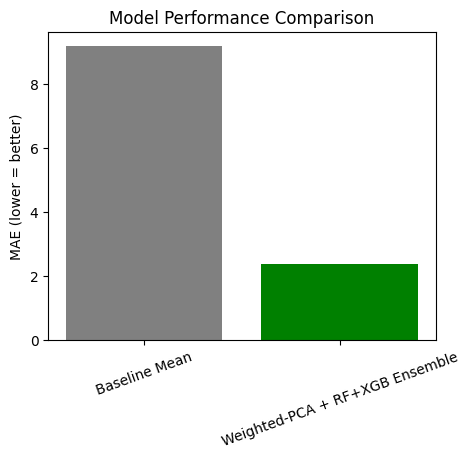

In [16]:
# STEP 14: Plot MAE comparison
plt.figure(figsize=(5,4))
x = np.arange(len(results))
plt.bar(x, results["MAE"], color=['gray', 'green'])
plt.xticks(x, results["Model"], rotation=20)
plt.ylabel("MAE (lower = better)")
plt.title("Model Performance Comparison")
plt.show()

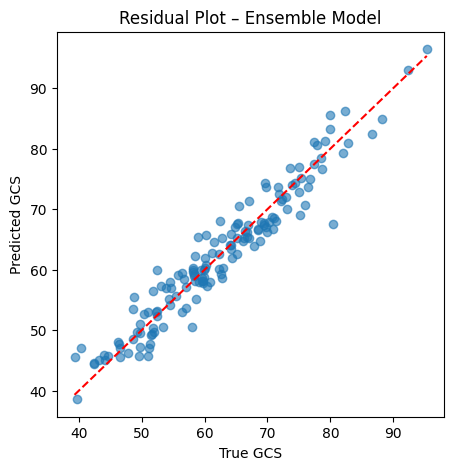

In [17]:
# STEP 15: Residual plot (predicted vs true)
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_ensemble, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True GCS")
plt.ylabel("Predicted GCS")
plt.title("Residual Plot – Ensemble Model")
plt.show()

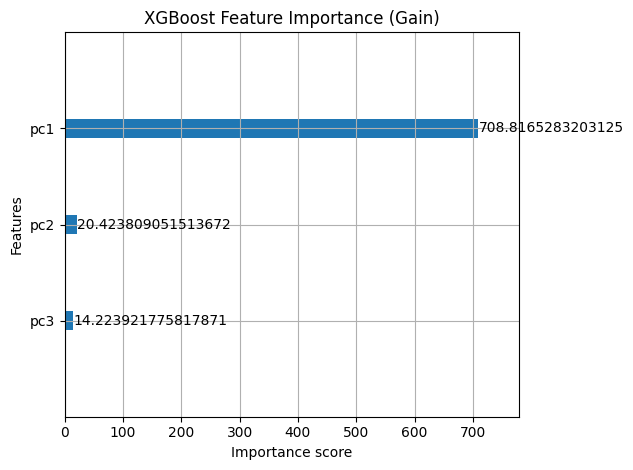

In [18]:
# STEP 16: built-in importance (gain = average improvement in split quality)
plot_importance(best_xgb, importance_type="gain", title="XGBoost Feature Importance (Gain)")
plt.tight_layout()
plt.show()

In [19]:
# STEP 17A – Ablation: sensitivity to number of trees
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score

test_results = []
for n in [100, 200, 300, 500, 800]:
    temp_model = XGBRegressor(
        n_estimators=n,
        max_depth=best_xgb.max_depth,
        learning_rate=best_xgb.learning_rate,
        objective='reg:squarederror',
        random_state=42
    )
    temp_model.fit(X_train, y_train)
    preds = temp_model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    test_results.append({"n_estimators": n, "MAE": mae, "R2": r2})

ablation_df = pd.DataFrame(test_results)
print(ablation_df)

   n_estimators       MAE        R2
0           100  2.432853  0.925276
1           200  2.413533  0.925360
2           300  2.404715  0.925473
3           500  2.492218  0.922041
4           800  2.597831  0.916707


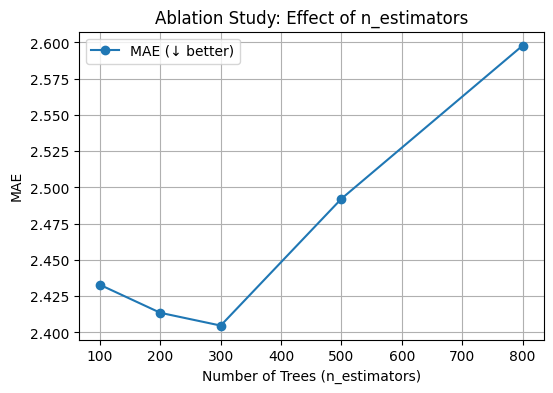

In [20]:
# STEP 17B – Plot ablation trend
plt.figure(figsize=(6,4))
plt.plot(ablation_df["n_estimators"], ablation_df["MAE"], marker="o", label="MAE (↓ better)")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("MAE")
plt.title("Ablation Study: Effect of n_estimators")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# STEP 17C – Identify top 5 largest prediction errors
y_pred_final = best_xgb.predict(X_test)
errors = np.abs(y_test - y_pred_final)

failures = pd.DataFrame({
    "Company": df_filled.loc[y_test.index, "company_name"],
    "True_GCS": y_test,
    "Predicted_GCS": y_pred_final,
    "Abs_Error": errors
}).sort_values("Abs_Error", ascending=False).head(5)

print("Top 5 representative failure cases:\n")
print(failures)

Top 5 representative failure cases:

                            Company   True_GCS  Predicted_GCS  Abs_Error
209           Wood, Tran and Cooper  80.441810      67.969818  12.471992
221              Harrison-Alexander  52.375204      59.778549   7.403345
583       Kirby, Wheeler and Romero  58.011255      50.969368   7.041887
578  Mcmillan, Fischer and Gonzalez  58.997186      65.851562   6.854377
522                       Green LLC  40.323955      47.102242   6.778286


In [ ]:
# STEP 17D – Residual visualization
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_final, alpha=0.6)
plt.plot([0,100],[0,100],'r--')
plt.xlabel("True GCS")
plt.ylabel("Predicted GCS")
plt.title("Residual Distribution – Failure Patterns")
plt.show()

In [22]:
# STEP 18A – Results summary table

summary = pd.DataFrame({
    "Model": ["Baseline Mean", "Weighted-PCA + RF+XGB Ensemble"],
    "MAE": [mae_base, mae_mean],
    "R²": [r2_base, r2_mean],
    "MAE_95CI": [f"[{mae_lo:.2f}, {mae_hi:.2f}]", f"[{mae_lo:.2f}, {mae_hi:.2f}]"],
    "R2_95CI": [f"[{r2_lo:.2f}, {r2_hi:.2f}]", f"[{r2_lo:.2f}, {r2_hi:.2f}]"]
})

print("📊 Final Model Performance Summary:\n")
print(summary.to_string(index=False))


📊 Final Model Performance Summary:

                         Model      MAE       R²     MAE_95CI      R2_95CI
                 Baseline Mean 9.178606 0.000000 [2.09, 2.68] [0.90, 0.95]
Weighted-PCA + RF+XGB Ensemble 2.374975 0.925464 [2.09, 2.68] [0.90, 0.95]


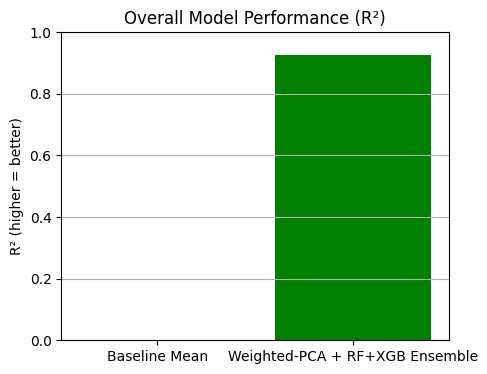

In [23]:
# STEP 18B – Visual summary
plt.figure(figsize=(5,4))
plt.bar(summary["Model"], summary["R²"], color=['grey','green'])
plt.title("Overall Model Performance (R²)")
plt.ylabel("R² (higher = better)")
plt.ylim(0,1)
plt.grid(axis='y')
plt.show()

In [25]:
# GCS Tier Mapping (lower score = higher risk)
def gcs_tier(score):
    if score >= 80:
        return "Leader (Low Risk)"
    elif score >= 60:
        return "Performer (Moderate Risk)"
    elif score >= 40:
        return "Learner (High Risk)"
    else:
        return "Lagging (Critical Risk)"

df_filled["GCS_Tier"] = df_filled["GCS"].apply(gcs_tier)
tier_summary = df_filled["GCS_Tier"].value_counts(normalize=True) * 100

print("📘 Distribution of companies by Green Credit Tier (%):\n")
print(tier_summary.round(2).to_string())

📘 Distribution of companies by Green Credit Tier (%):

GCS_Tier
Learner (High Risk)          48.3
Performer (Moderate Risk)    45.6
Leader (Low Risk)             4.7
Lagging (Critical Risk)       1.4
